In [1]:
import time
start_time=time.time()

In [2]:
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import lmfit
import json
import astropy.units as u
import bfunc
import pandas as pd
import corner
from scipy import interpolate
import pickle

Data load and region parameters

In [3]:
name = 'OrionS'

In [4]:
pickle_in = open('Results//SF' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [5]:
mask = SFresults['SF']["N pairs"] > 0

In [6]:
B = SFresults['b2'][mask]
r = SFresults['s'][mask]
pc =  SFresults['pc']
pix =  SFresults['pix']
box_size =  SFresults['box_size']
pc_per_arcsec = pc

In [7]:
# Merge first K points
K = 3
r[K] = np.mean(r[:K])
B[K] = np.mean(B[:K])
r = r[K:]
B = B[K:]

In [8]:
model = lmfit.Model(bfunc.bfunc04s)
model.param_names

['r0', 'sig2', 'm', 's0', 'noise', 'box_size']

In [9]:
# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)

# sig2 between 1/4 and 2 x max value of B(r)
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2 * B.max())

# m between 1/2 and 5/3
model.set_param_hint("m", value=1.0, min=0.5, max=1.667)

# Seeing RMS between 0.1 and 1.5 arcsec
model.set_param_hint("s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=1.5 * pc_per_arcsec)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
model.set_param_hint("box_size", value=box_size, vary=False)

In [10]:
pd.DataFrame(model.param_hints)

,r0,sig2,m,s0,noise,box_size
value,0.045405,11.801099,1.000,0.000994,0.041262,0.454053
min,0.004541,5.900549,0.500,0.000199,0.000000,NaN
max,0.908106,47.204394,1.667,0.002982,0.247575,NaN
vary,NaN,NaN,NaN,NaN,NaN,False


In [11]:
relative_uncertainty = 0.02
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5 * box_size
weights[large_scale] /= 8.0
weights[:3] /= 3.0

In [12]:
to_fit = ~large_scale
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

In [13]:
result

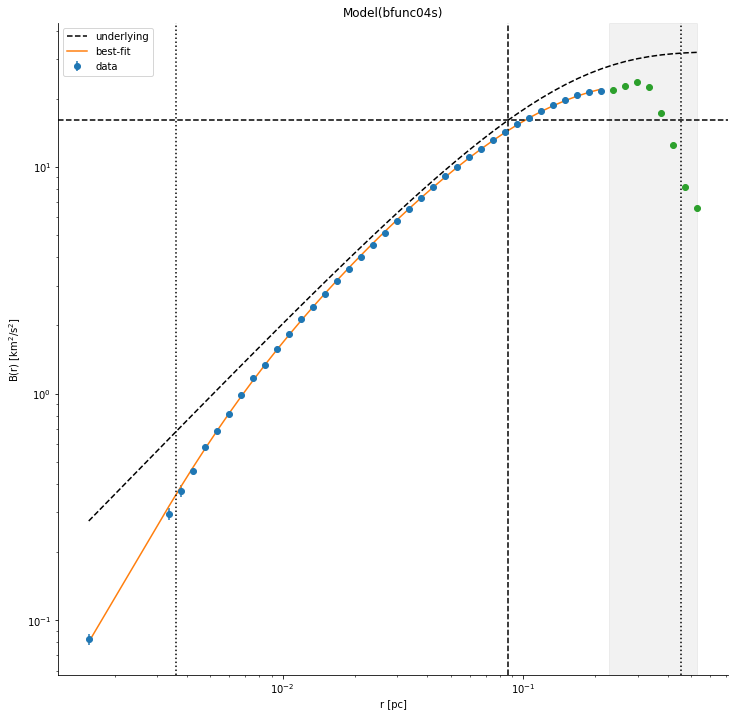

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(result.params["box_size"].value, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(result.params["box_size"].value / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine();

emcee

In [15]:
emcee_kws = dict(steps=5000, burn=500, thin=50, is_weighted=True,
                 progress=False, workers=16)
emcee_params = result.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [16]:
result_emcee = model.fit(
    data=B[to_fit], r=r[to_fit], weights=weights[to_fit], params=emcee_params, method='emcee',
    nan_policy='omit', fit_kws=emcee_kws,
)

In [17]:
result_emcee

Text(0, 0.5, 'acceptance fraction')

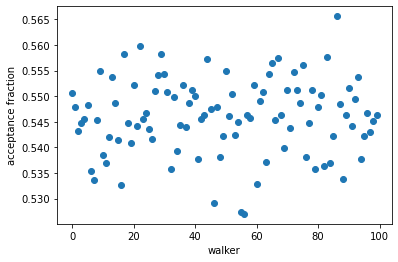

In [18]:
plt.plot(result_emcee.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [19]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee.params):
        try:
            print(f'{p} = {result_emcee.acor[i]:.3f}')
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 57.841
sig2 = 57.644
m = 56.613
s0 = 55.041
noise = 54.233


In [20]:
fancy_names = {
    "r0": "Corr. length:\n" + r"$r_0$ [parsec]",
    "sig2": "Vel. variance:\n" + r"$\sigma^2$ [km$^2$ s$^{-1}$]",
    "m": "Power-law slope:\n" + r"$m$",
    "s0": "RMS seeing:\n" + r"$s_0$ [parsec]",
    "noise": "Noise:\n" + r"[km$^2$ s$^{-1}$]",
}

In [21]:
def corner_plot(result_emcee, result_orig, suffix, data_ranges=None):
    # We need to remove the frozen parameters from the list before passing it as the truths argument
    truths = [_.value for _ in result_orig.params.values() if _.vary]    
    fig = corner.corner(
        result_emcee.flatchain, 
        labels=[fancy_names[_] for _ in result_emcee.var_names],
        truths=truths,
        labelpad=0.2,
        range=[0.995]*len(truths) if data_ranges is None else data_ranges,
        color="#b04060",
        hist_kwargs=dict(color="k"),
        data_kwargs=dict(color="k"),
    )
    sns.despine()
    fig.set_size_inches(15, 15)
    fig.tight_layout(h_pad=0, w_pad=0)
    #fig.savefig(f"corner-emcee-{suffix}.pdf");

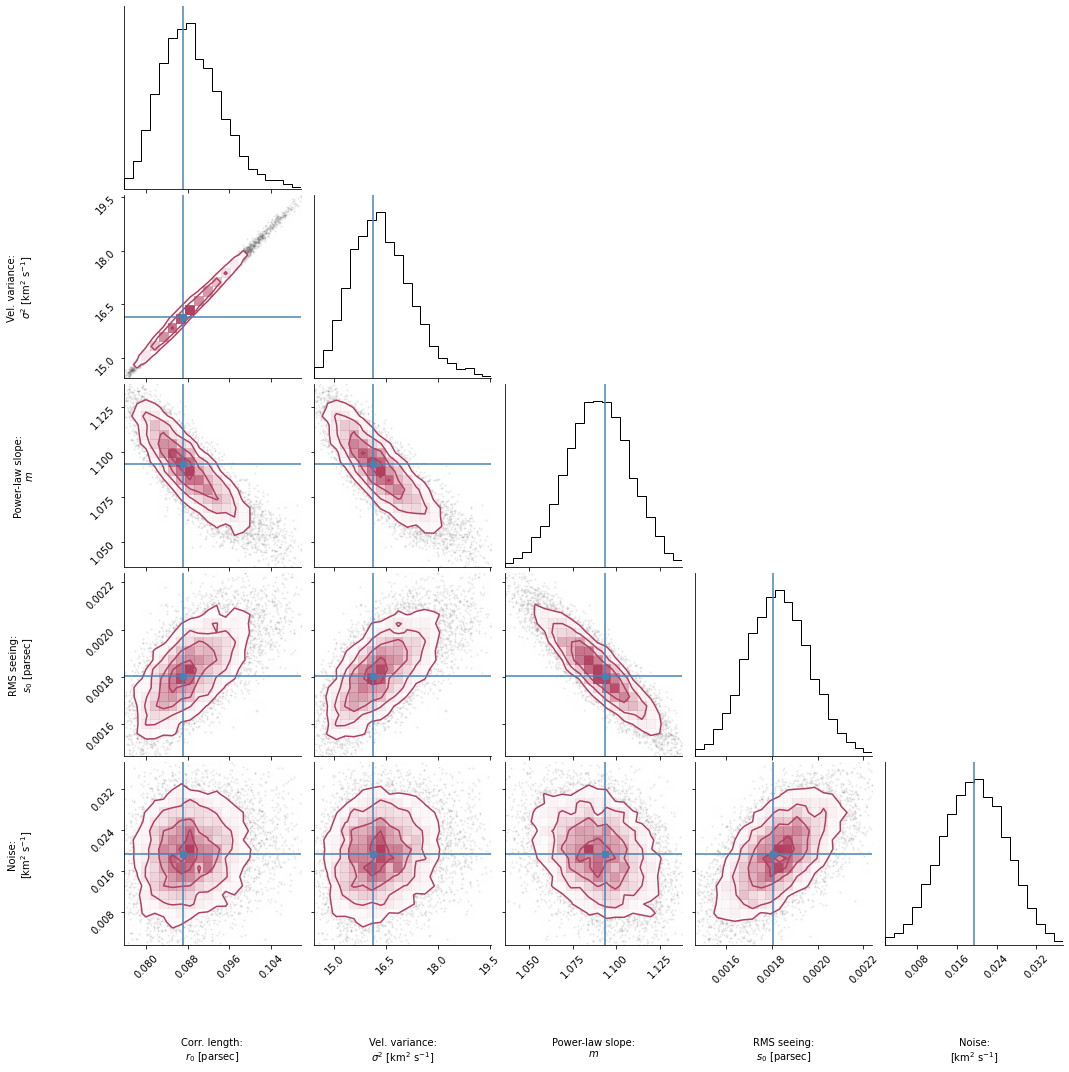

In [22]:
corner_plot(result_emcee, result, "orion");

In [23]:
span_kwds = dict(zorder=-1, linestyle="solid")
def spread_span(
    ax, 
    values, 
    orient="h", 
    pranges=[[2.5, 97.5], [16, 84]], 
    alphas=[0.1, 0.3],
    colors=["m", "m"],
):
    """
    Show the spread of values as overlapping translucent boxes.
    A box is plotted for each percentile range in pranges
    Orientation (horizontal or vertical) is controlled by orient
    """
    for prange, alpha, color in zip(pranges, alphas, colors):
        if orient=="h":
            ax.axhspan(*np.percentile(values, prange), alpha=alpha, color=color, **span_kwds)
        else:
            ax.axvspan(*np.percentile(values, prange), alpha=alpha, color=color, **span_kwds)

# Opaque white box to use as bbox argument for labels (ax.text() or ax.annotate())
whitebox = dict(facecolor="white", pad=5, edgecolor="0.5", linewidth=0.5)
label_kwds = dict(ha="center", va="center", bbox=whitebox, zorder=100)
label_kwds2 = dict(ha="left", va="center", bbox=whitebox, zorder=100)

In [24]:
def strucfunc_plot(result_emcee, r, B, to_fit, source_name, suffix):

    xmin, xmax = 5e-4 * box_size, 8 * box_size
    ymin, ymax = 5e-4 * B.max(), 8 * B.max()    
    xarr = np.logspace(np.log10(xmin), np.log10(xmax))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    best = result_emcee.best_values
    
    # Plot the data
    yerr = 1.0 / result_emcee.weights
    data_points = ax.errorbar(r[to_fit], B[to_fit], yerr=yerr, fmt="o")
    c_data = data_points[0].get_color()
    ax.annotate(
        "observed", 
        (r[3], B[3]), 
        xytext=(40, -20), 
        textcoords="offset points",
        color=c_data,
        arrowprops=dict(arrowstyle="->", color=c_data, shrinkB=8),
        **label_kwds2
    )

    # Plot the full model ˚including without instrumental effects
    Ba = bfunc.bfunc04s(xarr, **best)
    line_apparent = ax.plot(xarr, Ba)
    c_apparent = line_apparent[0].get_color()
    xa = 0.5 * (r[1] + r[2])
    ya = bfunc.bfunc04s(xa, **best)
    ax.annotate(
        "model",
        (xa, ya),
        xytext=(20, -40), 
        textcoords="offset points",
        color=c_apparent,
        arrowprops=dict(arrowstyle="->", color=c_apparent, shrinkB=8),
        **label_kwds2,
    )
    #ax.text(xmax / 1.5, Ba[-1], "model apparent", color=c_apparent, **label_kwds2)
    
    # Plot the underlying model without instrumental effects
    Bu = bfunc.bfunc00s(xarr, best["r0"], best["sig2"], best["m"])
    line_true = ax.plot(xarr, Bu, linestyle="dashed")
    c_true = line_true[0].get_color()
    ax.annotate(
        "model true",
        (xarr[10], Bu[10]),
        xytext=(-30, 60), 
        textcoords="offset points",
        color=c_true,
        arrowprops=dict(arrowstyle="->", color=c_true, shrinkB=8),
        **label_kwds,
    )
    #ax.text(xmax / 1.5, Bu[-1], "model true", color=c_true, **{**label_kwds2, "zorder": 99})
    
    
    # Plot the fit results
    # result_emcee.plot_fit(ax=ax)
    
    # Plot a random sample of the emcee chain
    inds = np.random.randint(len(result_emcee.flatchain), size=100)
    for ind in inds:
        sample = result_emcee.flatchain.iloc[ind]
        try: 
            s0 = sample.s0
        except AttributeError:
            s0 = best["s0"]
        Bsamp = bfunc.bfunc04s(xarr, sample.r0, sample.sig2, sample.m, s0, sample.noise, best["box_size"])
        ax.plot(xarr, Bsamp, alpha=0.05, color="orange")
        Busamp = bfunc.bfunc00s(xarr, sample.r0, sample.sig2, sample.m)
        ax.plot(xarr, Busamp, alpha=0.05, color="g")
    
    # Dotted lines for 2 x rms seeing and for box size
    ax.axvline(best["s0"], color="k", linestyle="dotted")
    try:
        spread_span(ax, result_emcee.flatchain.s0, orient="v")
    except AttributeError:
        # Case where s0 parameter is frozen
        pass
    #ax.text(best["s0"], 1.5 * ymin, r"$s_0$", **label_kwds)
    ax.annotate(
        r"$s_0$",
        (best["s0"], 1.5 * ymin),
        xytext=(-40, 0), 
        textcoords="offset points",
        color="k",
        arrowprops=dict(arrowstyle="->", color="k", shrinkB=2),
        **label_kwds,
    )
    
    ax.axvline(best["box_size"], color="k", linestyle="dotted")
    ax.text(best["box_size"], 1.5 * ymin, r"$L$", **label_kwds)
    
    # Dashed lines for best-fit r0 and sig2
    ax.axvline(best["r0"], color="k", linestyle="dashed")
    spread_span(ax, result_emcee.flatchain.r0, orient="v")
    # ax.text(best["r0"], 1.5 * ymin, r"$r_0$", **label_kwds)
    ax.annotate(
        r"$r_0$",
        (best["r0"], 1.5 * ymin),
        xytext=(40, 20), 
        textcoords="offset points",
        color="k",
        arrowprops=dict(arrowstyle="->", color="k", shrinkB=2),
        **label_kwds,
    )
    
    ax.axhline(best["sig2"], color="k", linestyle="dashed")
    spread_span(ax, result_emcee.flatchain.sig2, orient="h")
    ax.text(1.5 * xmin, best["sig2"], r"$\sigma^2$", **label_kwds)

    if np.any(~to_fit):
        # Add in the points not included in fit
        ax.plot(r[large_scale], B[large_scale], "o", color=c_data, mew=3, fillstyle="none")
        # Translucent overlay box to indicate the large scale values that are excluded from the fit
        ax.axvspan(box_size / 2, ymax, color="w", alpha=0.5, zorder=50)

        
    ax.text(np.sqrt(xmin * xmax), ymax / 1.5, source_name, fontsize="large", **label_kwds)
    ax.set(
        xscale = "log",
        yscale = "log",
        xlabel = "Separation: $r$ [pc]",
        ylabel = r"Structure function: $B(r)$ [km$^{2}$/s$^{2}$]",
        xlim = [xmin, xmax],
        ylim = [ymin, ymax],
    )
    sns.despine()
    fig.tight_layout()
    #fig.savefig(f"sf-emcee-{suffix}.pdf");

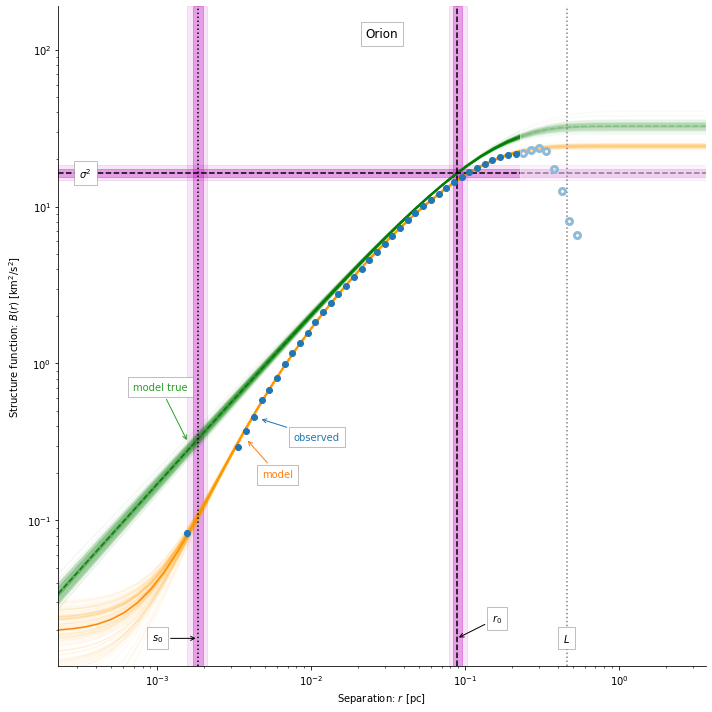

In [25]:
strucfunc_plot(result_emcee, r, B, to_fit, "Orion", "orion")

CIresults = {'result_emcee': result_emcee,
            'result' : result
          }

f = open('Results//CI' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [26]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 47.06469202041626 seconds ---
